In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from math import cos as cos
from math import sin as sin
from math import pi as pi
import random


from scipy.sparse import csr_matrix, lil_matrix
import scipy as sp

# Functions

### data generating functions

In [2]:
def random_initializing():
    '''
    set a random cone's parameters
    return : R_0 = (x_0,y_0,z_0),n = (n_x,n_y,n_z),thta_cs
    
    '''
    theta_cs = np.random.uniform(0,pi/2)
    theta = np.random.uniform(0,pi)
    phi = np.random.uniform(0,2*pi)
    x_0 = np.random.uniform(-1,1)
    y_0 = np.random.uniform(-1,1)
    z_0 = np.random.uniform(-1,1)
    n_x = sin(theta) * cos(phi) 
    n_y = sin(theta) * sin(phi) 
    n_z = cos(theta) 
    return x_0,y_0,z_0,theta_cs,n_x,n_y,n_z

In [3]:
def space(mesh_theta,mesh_phi):
    '''
    discrete the parameter space: divide theta into (mesh_theta = N_theta = pi / delta_theta) parts
                                  divide phi into (mesh_phi = N_phi = 2 pi / delta_phi) parts
    return: a mesh_theta*mesh_phi dimension matrix wich its elements are theta,phi of that point
    
    '''
    #Meshgrid
    phi = np.linspace(0, 2*pi , mesh_phi)
    theta = np.linspace(0, pi , mesh_theta)
    phi_s, theta_s = np.meshgrid(phi,theta)
    return phi_s,theta_s

In [284]:
def cone_sphere_intersection_with_error(x_0,y_0,z_0,theta_cs,n_x,n_y,n_z,phi_s,theta_s,mesh_theta,mesh_phi):
    '''
    find intersection curve's points numerically(by finding error for all possible theta and phi) and show them with a matrix which its nonzero(1) elements are intersection points
    input : x_0,y_0,z_0,theta_cs,n_x,n_y,n_z : cone parameters
            phi_s,theta_s : from "space" function - discrete parameter space
            mesh_theta,mesh_phi : they use for calculate the error (find delta_theta and delta_phi)
    return : a mesh_theta*mesh_phi dimension matrix which its nonzero(1) elements are intersection points
    
    '''
    
    delta_theta = pi / mesh_theta
    delta_phi = 2 * pi / mesh_phi
    
    sin_theta = np.sin(theta_s)
    cos_theta = np.cos(theta_s) 
    sin_phi = np.sin(phi_s)
    cos_phi = np.cos(phi_s)
    
    X = sin_theta * cos_phi - x_0
    Y = sin_theta * sin_phi - y_0
    Z = cos_theta - z_0
    rsize = np.sqrt(X**2 + Y**2 + Z**2)
    
    function = X * n_x + Y * n_y + Z * n_z - np.multiply(rsize,np.cos(theta_cs))
    
    deltaf_deltatheta = cos_theta * (cos_phi * n_x + sin_phi * n_y) - sin_theta * n_z + np.cos(theta_cs) * np.divide((cos_theta * (cos_phi * x_0 + sin_phi * y_0) - sin_theta * z_0) , rsize)
    deltaf_deltaphi = sin_theta * (cos_phi * n_y - sin_phi * n_x) + np.cos(theta_cs) * sin_theta * np.divide((cos_phi * y_0 - sin_phi * x_0) , rsize)
    error_function = np.sqrt(np.add(np.multiply(deltaf_deltaphi,deltaf_deltaphi) * (delta_phi) ** 2,np.multiply(deltaf_deltatheta,deltaf_deltatheta) * (delta_theta) ** 2))
    
    function[abs(function) <= error_function] = 0
    function[abs(function) != 0] = -1
    function = function + 1
    if function.any() == 0:
        theta_cs = -1 # for cones which have no interaction
        
    return function, theta_cs

In [5]:
def data_genarate_with_error_random(mesh_theta,mesh_phi,phi_s,theta_s):
    '''
    find intersection curve's points numerically(by finding error for all possible theta and phi) for a random cone and show them with a matrix which its nonzero(1) elements are intersection points
    input :mesh_theta,mesh_phi : they use for calculate the error (find delta_theta and delta_phi)
    return : intersection :a mesh_theta*mesh_phi dimension sparse matrix which its nonzero(1) elements are intersection points
             x_0,y_0,z_0,theta_cs,n_x,n_y,n_z : the random cone's parameters
    '''
    #phi_s,theta_s = space(mesh_theta,mesh_phi)
    x_0,y_0,z_0,theta_cs,n_x,n_y,n_z = random_initializing()
    intersection, theta_cs = cone_sphere_intersection_with_error(x_0,y_0,z_0,theta_cs,n_x,n_y,n_z,phi_s,theta_s,mesh_theta,mesh_phi)
    return sp.sparse.csr_matrix(intersection.reshape(-1)),x_0,y_0,z_0,theta_cs,n_x,n_y,n_z

In [6]:
def sample(n_sample,mesh_theta,mesh_phi):
    '''
    generate data with special shape for our estimator
    input :mesh_theta,mesh_phi : number of features = mesh_theta*mesh_phi -> reshape(-1)
    return : x: shape(n_sample,n_feature) sparse matrix for optimization the run run time
             y: shape(n_sample,1) 1 output-theta_cs as an output
             the data just include cones with intersection
    '''
    x = lil_matrix((n_sample,mesh_theta * mesh_phi))
    y = np.zeros((n_sample))
    phi_s,theta_s = space(mesh_theta,mesh_phi)
    i = 0
    while i < n_sample:
        intersection,x_0,y_0,z_0,theta_cs,n_x,n_y,n_z = data_genarate_with_error_random(mesh_theta,mesh_phi,phi_s,theta_s)
        if theta_cs != -1: # creat samples just with cones that have interaction
            y[i] = theta_cs
            x[i,:] = sp.sparse.csr_matrix(intersection)
            i = i + 1
    return x, y

# model 1: SVR

In [7]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [8]:
#the intersection matrix dimension
mesh_theta,mesh_phi = 10, 20 
#meshgrid
phi_s,theta_s = space(mesh_theta,mesh_phi)

In [9]:
#generating train samples for model with one output
N_sample_1 = 10000 #number of cones
N_feature_1 = mesh_theta * mesh_phi #intersection matrix
N_outputs_1 = 1 # theta_cs as output
N_test_1 = 10000
print(N_sample_1,' samples with ',N_feature_1,'features')

10000  samples with  200 features


In [10]:
%%time
#train set
x_train_1, y_train_1 = sample(N_sample_1,mesh_theta,mesh_phi)
print('train samples shape' ,x_train_1.shape, y_train_1.shape)
#test set
x_test_1, y_test_1 = sample(N_test_1,mesh_theta,mesh_phi)
print('test samples shape' ,x_train_1.shape, y_train_1.shape)

train samples shape (10000, 200) (10000,)
test samples shape (10000, 200) (10000,)
Wall time: 15.6 s


### Grid search to find the best kernel and gamma

In [59]:
from sklearn.model_selection import GridSearchCV

In [60]:
%%time
# x and y for gridsearch
x_train_gridsearch_1, y_train_gridsearch_1 = sample(N_sample_1,mesh_theta,mesh_phi)

Wall time: 11.2 s


In [54]:
# different parameters 
parameters = [{'kernel': ['rbf'], 'gamma': ['auto','scale'],
                     'C': [0.1,1,10,100], 'epsilon': [0.1,0.3]},{'kernel': ['poly'], 'gamma': ['auto','scale'],
                     'C': [0.1,1,10,100], 'epsilon': [0.1,0.3], 'degree': [2,3,4,10,20]},{'kernel': ['sigmoid'], 'gamma': ['auto','scale'],
                     'C': [0.1,1,10,100], 'epsilon': [0.1,0.3]},
                    {'kernel': ['linear'], 'gamma': ['auto','scale'], 'C': [0.1,1,10,100], 'epsilon': [0.1,0.3]}]

In [62]:
%%time
print("# Tuning hyper-parameters for neg_mean_squared_error")
print()

gridsearch_1 = GridSearchCV(SVR(), parameters, scoring= 'neg_mean_squared_error', cv=2)
gridsearch_1.fit(x_train_gridsearch_1, y_train_gridsearch_1)

print("Best parameters set found on development set:")
print()
print(gridsearch_1.best_params_)
print()
print("Grid scores on development set:")
print()
means = gridsearch_1.cv_results_['mean_test_score']
stds = gridsearch_1.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gridsearch_1.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()


# Tuning hyper-parameters for neg_mean_squared_error

Best parameters set found on development set:

{'C': 0.01, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}

Grid scores on development set:

-0.130 (+/-0.001) for {'C': 0.01, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}

Wall time: 39.9 s


In [45]:
import pandas as pd
gridsearch_df_1 = pd.DataFrame(gridsearch_1.cv_results_)

In [46]:
grid_poly = gridsearch_df_1.drop(columns=['params','std_fit_time','std_score_time','split0_test_score','split1_test_score'])

In [47]:
grid_poly

,mean_fit_time,mean_score_time,param_C,param_degree,param_epsilon,param_gamma,param_kernel,mean_test_score,std_test_score,rank_test_score
0,5.601639,4.756516,0.01,2,0.1,auto,poly,-0.198165,0.000554,35
1,5.172529,3.976261,0.01,2,0.1,scale,poly,-0.129659,0.000647,6
2,4.689129,3.382524,0.01,2,0.3,auto,poly,-0.199127,0.000508,37
3,3.860769,3.187030,0.01,2,0.3,scale,poly,-0.131896,0.000239,7
4,6.338977,5.502272,0.01,3,0.1,auto,poly,-0.205114,0.000572,39
5,6.043507,4.758428,0.01,3,0.1,scale,poly,-0.134684,0.000327,14
6,4.319695,3.283427,0.01,3,0.3,auto,poly,-0.205133,0.000547,40
7,4.072827,2.855198,0.01,3,0.3,scale,poly,-0.137394,0.000152,16
8,6.733554,5.844207,0.01,10,0.1,auto,poly,-0.205971,0.000604,48
9,6.353263,6.119938,0.01,10,0.1,scale,poly,-0.153477,0.000275,20


In [42]:
grid_sigmoid

,mean_fit_time,mean_score_time,param_C,param_epsilon,param_gamma,param_kernel,mean_test_score,std_test_score,rank_test_score
0,5.390655,4.511052,0.01,0.1,auto,sigmoid,-0.158560,0.000110,7
1,5.643351,4.324667,0.01,0.1,scale,sigmoid,-0.136735,0.000858,6
2,3.529984,2.553584,0.01,0.3,auto,sigmoid,-0.163712,0.000055,8
3,3.168654,2.695059,0.01,0.3,scale,sigmoid,-0.136641,0.000728,5
4,5.416659,4.510877,0.1,0.1,auto,sigmoid,-0.131066,0.000891,1
5,6.436335,5.307976,0.1,0.1,scale,sigmoid,-2.612748,0.029705,12
6,2.984122,2.305803,0.1,0.3,auto,sigmoid,-0.131228,0.000935,2
7,5.723870,4.571191,0.1,0.3,scale,sigmoid,-2.566481,0.030944,11
8,5.700533,4.160378,1,0.1,auto,sigmoid,-0.136126,0.000628,4
9,6.243250,5.265460,1,0.1,scale,sigmoid,-278.632836,3.538665,13


In [41]:
grid_linear

,mean_fit_time,mean_score_time,param_C,param_epsilon,param_gamma,param_kernel,mean_test_score,std_test_score,rank_test_score
0,6.106200,3.971200,0.01,0.1,auto,linear,-0.137007,0.000372,9
1,6.405238,4.576711,0.01,0.1,scale,linear,-0.137007,0.000372,9
2,3.329616,2.459995,0.01,0.3,auto,linear,-0.133063,0.001059,1
3,3.303501,2.168461,0.01,0.3,scale,linear,-0.133063,0.001059,1
4,0.537573,0.350570,0.01,0.6,auto,linear,-0.143964,0.000028,17
5,0.562783,0.337361,0.01,0.6,scale,linear,-0.143964,0.000028,17
6,7.223003,4.543055,0.1,0.1,auto,linear,-0.140608,0.000436,11
7,6.836706,3.921799,0.1,0.1,scale,linear,-0.140608,0.000436,11
8,4.068440,2.476466,0.1,0.3,auto,linear,-0.135198,0.000986,3
9,4.332135,2.832193,0.1,0.3,scale,linear,-0.135198,0.000986,3


In [31]:
grid_rbf

,mean_fit_time,mean_score_time,param_C,param_epsilon,param_gamma,param_kernel,mean_test_score,std_test_score,rank_test_score
0,5.388866,4.916909,0.01,0.1,auto,rbf,-0.143995,0.000295,15
1,5.408421,5.728373,0.01,0.1,scale,rbf,-0.132959,0.000448,11
2,3.702305,3.502796,0.01,0.3,auto,rbf,-0.148818,0.000586,19
3,3.695125,3.493668,0.01,0.3,scale,rbf,-0.135587,0.000289,13
4,1.150400,1.043304,0.01,0.6,auto,rbf,-0.173863,0.000119,24
5,0.874969,0.726944,0.01,0.6,scale,rbf,-0.159564,0.000003,23
6,5.624619,5.028712,0.1,0.1,auto,rbf,-0.130240,0.000724,8
7,5.077927,5.155476,0.1,0.1,scale,rbf,-0.123668,0.000098,3
8,3.038585,2.920667,0.1,0.3,auto,rbf,-0.129730,0.001035,7
9,2.785921,2.759589,0.1,0.3,scale,rbf,-0.122800,0.000537,2


### Tuning the parameter(C) of SVR with validation curve 

In [10]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import validation_curve

In [11]:
%%time
# x and y for validation curve
x_train_validation_curve_1, y_train_validation_curve_1 = sample(N_sample_1,mesh_theta,mesh_phi)

Wall time: 6.07 s


In [12]:
# the range of one parameter for optimization
param_range_1 = np.logspace(-5, 5, 5)
# estimatior with best parameters of grid search
validation_curve_1 = SVR(kernel='poly', gamma='scale', epsilon=0.1, degree=2)

In [13]:
%%time
train_scores_validation_1, test_scores_validation_1 = validation_curve(validation_curve_1, x_train_validation_curve_1, y_train_validation_curve_1, param_name="C", param_range=param_range_1,
    scoring="neg_mean_squared_error", cv=3)

Wall time: 11min 13s


In [14]:
train_scores_mean_validation_1 = -np.mean(train_scores_validation_1, axis=1)
train_scores_std_validation_1 = np.std(train_scores_validation_1, axis=1)
test_scores_mean_validation_1 = -np.mean(test_scores_validation_1, axis=1)
test_scores_std_validation_1 = np.std(test_scores_validation_1, axis=1)

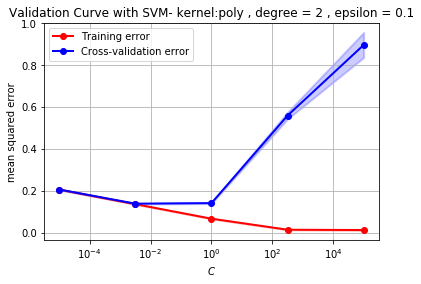

In [15]:
plt.grid()
plt.title("Validation Curve with SVM- kernel:poly , degree = 2 , epsilon = 0.1")
plt.xlabel(r"$C$")
plt.ylabel("mean squared error")
lw = 2
plt.semilogx(param_range_1, train_scores_mean_validation_1,'o-', label="Training error",
             color="red", lw=lw)
plt.fill_between(param_range_1, train_scores_mean_validation_1 - train_scores_std_validation_1,
                 train_scores_mean_validation_1 + train_scores_std_validation_1, alpha=0.2,
                 color="red", lw=lw)
plt.semilogx(param_range_1, test_scores_mean_validation_1,'o-', label="Cross-validation error",
             color="blue", lw=lw)
plt.fill_between(param_range_1, test_scores_mean_validation_1 - test_scores_std_validation_1,
                 test_scores_mean_validation_1 + test_scores_std_validation_1, alpha=0.2,
                 color="blue", lw=lw)
plt.legend(loc="best")
plt.savefig('validationcurve11.png',dpi=300)
#plt.show()

### learning curve

In [16]:
from sklearn.model_selection import learning_curve

In [17]:
%%time
N_learning_1 = 50000
# x and y for learning curve
x_train_learning_curve_1, y_train_learning_curve_1 = sample(N_learning_1,mesh_theta,mesh_phi)

Wall time: 27.1 s


In [18]:
train_sizes_1 = np.linspace(.1, 1.0, 5)

In [19]:
# estimator with best parameters of grid search and validation curve
learning_curve_1 = SVR(kernel='poly', gamma='scale', C=0.005, epsilon=0.1, degree=2)

In [20]:
%%time
train_sizes_learning_curve_1, train_scores_learning_curve_1, test_scores_learning_curve_1, fit_times_learning_curve_1, score_times_learning_curve_1 = learning_curve(learning_curve_1, x_train_learning_curve_1, y_train_learning_curve_1, cv=2, train_sizes=train_sizes_1,
                       scoring="neg_mean_squared_error", return_times=True)

Wall time: 19min 22s


In [21]:
train_scores_mean_learning_curve_1 = -np.mean(train_scores_learning_curve_1, axis=1)
train_scores_std_learning_curve_1 = np.std(train_scores_learning_curve_1, axis=1)
test_scores_mean_learning_curve_1 = -np.mean(test_scores_learning_curve_1, axis=1)
test_scores_std_learning_curve_1 = np.std(test_scores_learning_curve_1, axis=1)
fit_times_mean_learning_curve_1 = np.mean(fit_times_learning_curve_1, axis=1)
fit_times_std_learning_curve_1 = np.std(fit_times_learning_curve_1, axis=1)

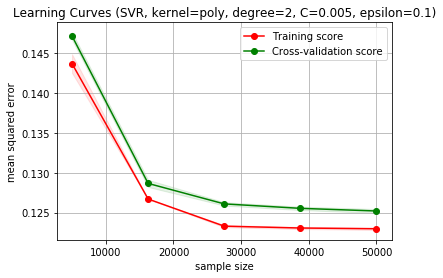

In [22]:
train_sizes_1 = np.linspace(.1, 1.0, 5) * N_learning_1

plt.grid()
plt.fill_between(train_sizes_1, train_scores_mean_learning_curve_1 - train_scores_std_learning_curve_1,
                         train_scores_mean_learning_curve_1 + train_scores_std_learning_curve_1, alpha=0.1,
                         color="r")
plt.fill_between(train_sizes_1, test_scores_mean_learning_curve_1 - test_scores_std_learning_curve_1,
                         test_scores_mean_learning_curve_1 + test_scores_std_learning_curve_1, alpha=0.1,
                         color="g")
plt.plot(train_sizes_1, train_scores_mean_learning_curve_1, 'o-', color="r",
                 label="Training score")
plt.plot(train_sizes_1, test_scores_mean_learning_curve_1, 'o-', color="g",
                 label="Cross-validation score")
plt.legend(loc="best")
plt.xlabel('sample size')
plt.ylabel('mean squared error')
plt.title(r"Learning Curves (SVR, kernel=poly, degree=2, C=0.005, epsilon=0.1)")


plt.savefig('learningcurve11.png',dpi=300)

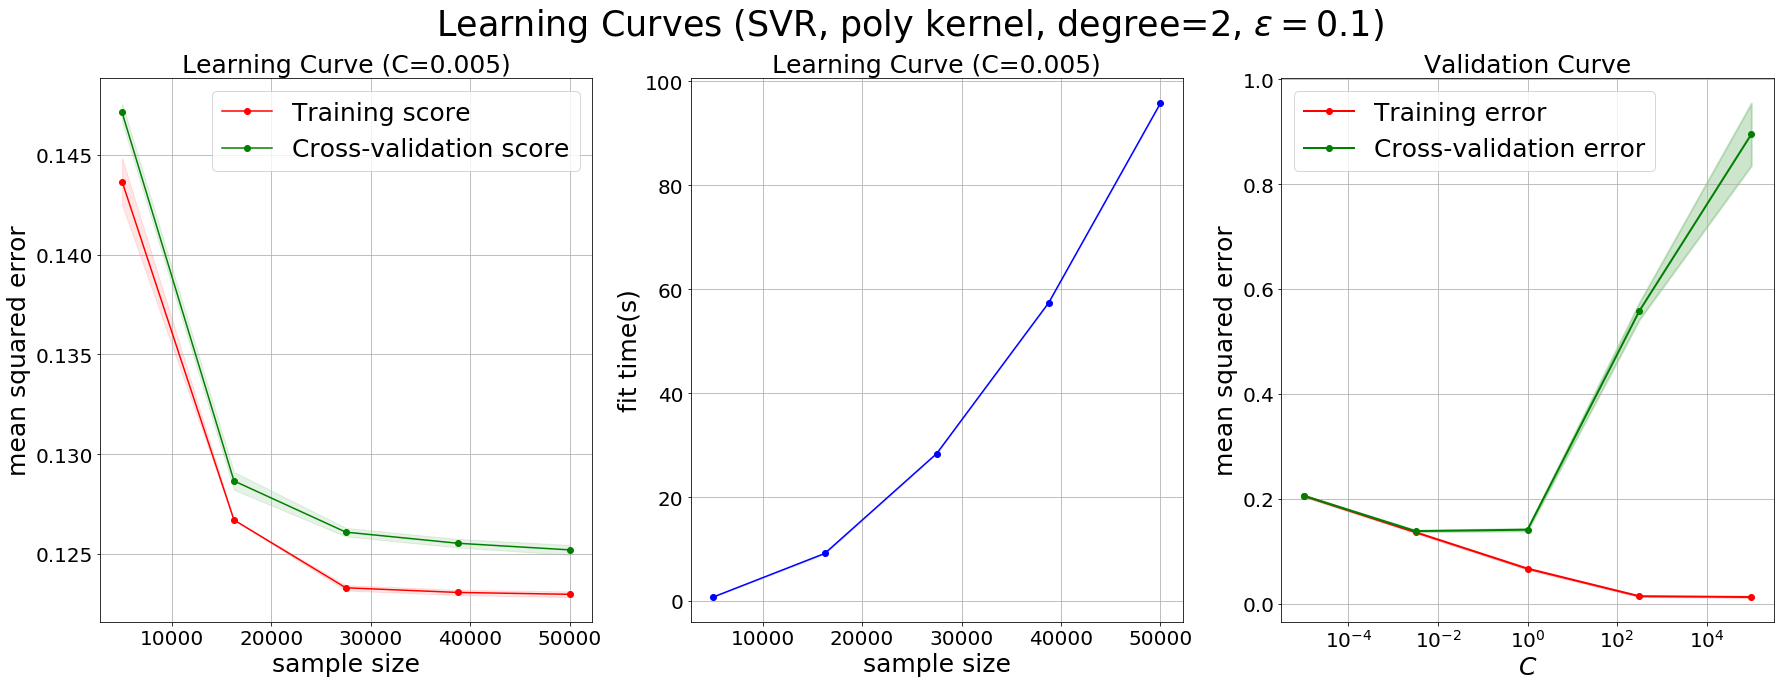

In [153]:
train_sizes_1 = np.linspace(.1, 1.0, 5) * N_learning_1

fig, (ax1, ax3, ax2) = plt.subplots(1, 3,figsize=(30,10))
# Plot learning curve
ax1.grid()
ax1.fill_between(train_sizes_1, train_scores_mean_learning_curve_1 - train_scores_std_learning_curve_1,
                         train_scores_mean_learning_curve_1 + train_scores_std_learning_curve_1, alpha=0.1,
                         color="r")
ax1.fill_between(train_sizes_1, test_scores_mean_learning_curve_1 - test_scores_std_learning_curve_1,
                         test_scores_mean_learning_curve_1 + test_scores_std_learning_curve_1, alpha=0.1,
                         color="g")
ax1.plot(train_sizes_1, train_scores_mean_learning_curve_1, 'o-', color="r",
                 label="Training score")
ax1.plot(train_sizes_1, test_scores_mean_learning_curve_1, 'o-', color="g",
                 label="Cross-validation score")
ax1.legend(loc="best")
ax1.set_xlabel("sample size")
ax1.set_ylabel("mean squared error")
ax1.set_title(r"Learning Curve (C=0.005)")

# plot fit times
ax3.grid()
ax3.fill_between(train_sizes_1, fit_times_mean_learning_curve_1 - fit_times_std_learning_curve_1,
                         fit_times_mean_learning_curve_1 + fit_times_std_learning_curve_1, alpha=0.1,
                         color="b")
ax3.plot(train_sizes_1, fit_times_mean_learning_curve_1, 'o-', color="b")
ax3.set_xlabel("sample size")
ax3.set_ylabel("fit time(s)")
ax3.set_title(r"Learning Curve (C=0.005)")


# plot validation curve
ax2.grid()
ax2.set_title("Validation Curve")
ax2.set_xlabel(r"$C$")
ax2.set_ylabel("mean squared error")

lw = 2
ax2.semilogx(param_range_1, train_scores_mean_validation_1,'o-', label="Training error",
             color="red", lw=lw)
ax2.fill_between(param_range_1, train_scores_mean_validation_1 - train_scores_std_validation_1,
                 train_scores_mean_validation_1 + train_scores_std_validation_1, alpha=0.2,
                 color="red", lw=lw)
ax2.semilogx(param_range_1, test_scores_mean_validation_1,'o-', label="Cross-validation error",
             color="green", lw=lw)
ax2.fill_between(param_range_1, test_scores_mean_validation_1 - test_scores_std_validation_1,
                 test_scores_mean_validation_1 + test_scores_std_validation_1, alpha=0.2,
                 color="green", lw=lw)
ax2.legend(loc="best")

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rc('axes',labelsize=25)
plt.rc('axes',titlesize=25)
plt.rc('figure',titlesize=35)
plt.rc('legend',fontsize=25)

fig.suptitle(r"Learning Curves (SVR, poly kernel, degree=2, $\epsilon=0.1$)")
fig.savefig('svrcurves11v.png',dpi=300)

In [102]:
# save the final results
np.save('train_sizes_1',train_sizes_1)
np.save('train_scores_mean_learning_curve_1',train_scores_mean_learning_curve_1)
np.save('train_scores_std_learning_curve_1',train_scores_std_learning_curve_1)
np.save('test_scores_mean_learning_curve_1',test_scores_mean_learning_curve_1)
np.save('test_scores_std_learning_curve_1',test_scores_std_learning_curve_1)
np.save('fit_times_mean_learning_curve_1',fit_times_mean_learning_curve_1)
np.save('fit_times_std_learning_curve_1',fit_times_std_learning_curve_1)
np.save('param_range_1',param_range_1)
np.save('train_scores_mean_validation_1',train_scores_mean_validation_1)
np.save('train_scores_std_validation_1',train_scores_std_validation_1)
np.save('test_scores_mean_validation_1',test_scores_mean_validation_1)
np.save('test_scores_std_validation_1',test_scores_std_validation_1)

### final fitting with best parameters and sample size 

In [241]:
# estimator with best parametrs from grid search and validation curve
best_model_1 = SVR(kernel='poly', gamma='scale', C=0.005, epsilon=0.1, degree=2)
# best sample size from learning curve and the fit times(to have enough data)
best_sample_size_1 = 50000

In [242]:
%%time
#train set
x_train_1, y_train_1 = sample(best_sample_size_1,mesh_theta,mesh_phi)
print('train samples shape' ,x_train_1.shape, y_train_1.shape)
#test set
x_test_1, y_test_1 = sample(best_sample_size_1,mesh_theta,mesh_phi)
print('test samples shape' ,x_train_1.shape, y_train_1.shape)

train samples shape (50000, 200) (50000,)
test samples shape (50000, 200) (50000,)
Wall time: 1min 19s


In [243]:
%%time
best_model_1.fit(x_train_1, y_train_1)
print('fit time')

fit time
Wall time: 8min 35s


In [251]:
%%time
y_predict_1 = best_model_1.predict(x_test_1)
print('predict time')

predict time
Wall time: 8min 34s


In [252]:
%%time
MSE_1 = mean_squared_error(y_test_1, y_predict_1)
print('MSE:' ,MSE_1)

MSE: 0.12577211316340292
Wall time: 1.99 ms


# model 2: KNN

In [24]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [25]:
#the intersection matrix dimension
mesh_theta,mesh_phi = 10, 20 
#meshgrid
phi_s,theta_s = space(mesh_theta,mesh_phi)

In [26]:
#generating train samples for model with one output
N_sample_2 = 10000 #number of cones
N_feature_2 = mesh_theta * mesh_phi #intersection matrix
N_outputs_2 = 1 # theta_cs as output
N_test_2 = 10000
print(N_sample_2,' samples with ',N_feature_2,'features')

10000  samples with  200 features


In [105]:
%%time
#train set
x_train_2, y_train_2 = sample(N_sample_2,mesh_theta,mesh_phi)
print('train samples shape' ,x_train_2.shape, y_train_2.shape)
#test set
x_test_2, y_test_2 = sample(N_test_2,mesh_theta,mesh_phi)
print('test samples shape' ,x_train_2.shape, y_train_2.shape)

train samples shape (10000, 200) (10000,)
test samples shape (10000, 200) (10000,)
Wall time: 16.7 s


In [106]:
# algorithm = brute for sparse matrix 
# KNeighborsRegressor(n_neighbors=5, algorithm='brute', metric='minkowski', metric_params=None)
# number of neighbors is free parameter

### Grid search to find the best Number of neighbors

In [51]:
from sklearn.model_selection import GridSearchCV

In [52]:
%%time
# x and y for gridsearch
x_train_gridsearch_2, y_train_gridsearch_2 = sample(N_sample_2,mesh_theta,mesh_phi)

Wall time: 6.53 s


In [53]:
# different parameters 
parameters = [{'n_neighbors': [1,2,3,4,5,10,20,40,60,100,200,500]}]

In [54]:
%%time
print("# Tuning hyper-parameters for neg_mean_squared_error")
print()

gridsearch_2 = GridSearchCV(KNeighborsRegressor(algorithm='brute', metric='minkowski', metric_params=None), parameters, scoring= 'neg_mean_squared_error', cv=5)
gridsearch_2.fit(x_train_gridsearch_2, y_train_gridsearch_2)

print("Best parameters set found on development set:")
print()
print(gridsearch_2.best_params_)
print()
print("Grid scores on development set:")
print()
means = gridsearch_2.cv_results_['mean_test_score']
stds = gridsearch_2.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gridsearch_2.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()



# Tuning hyper-parameters for neg_mean_squared_error

Best parameters set found on development set:

{'n_neighbors': 20}

Grid scores on development set:

-0.198 (+/-0.013) for {'n_neighbors': 1}
-0.150 (+/-0.007) for {'n_neighbors': 2}
-0.135 (+/-0.007) for {'n_neighbors': 3}
-0.127 (+/-0.006) for {'n_neighbors': 4}
-0.122 (+/-0.007) for {'n_neighbors': 5}
-0.113 (+/-0.006) for {'n_neighbors': 10}
-0.110 (+/-0.006) for {'n_neighbors': 20}
-0.113 (+/-0.006) for {'n_neighbors': 40}
-0.120 (+/-0.008) for {'n_neighbors': 60}
-0.135 (+/-0.010) for {'n_neighbors': 100}
-0.168 (+/-0.013) for {'n_neighbors': 200}
-0.224 (+/-0.016) for {'n_neighbors': 500}

Wall time: 1min 6s


In [111]:
import pandas as pd
gridsearch_df_2 = pd.DataFrame(gridsearch_2.cv_results_)

In [142]:
grid_2

,mean_fit_time,mean_score_time,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
0,0.007780,0.983209,1,-0.199874,0.003073,11
1,0.006781,0.956924,2,-0.152670,0.001580,9
2,0.005386,1.031435,3,-0.137173,0.002082,8
3,0.006926,1.123958,4,-0.128792,0.001652,6
4,0.007192,1.129028,5,-0.123818,0.001714,5
5,0.007234,1.092073,10,-0.115592,0.002557,3
6,0.007790,1.067244,20,-0.111739,0.002476,1
7,0.007181,1.111527,40,-0.114545,0.002835,2
8,0.007408,1.276914,60,-0.120723,0.003370,4
9,0.009508,1.242042,100,-0.135267,0.004013,7


### Tuning the parameters of KNN with validation curve find number of neighbors

In [27]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import validation_curve

In [28]:
%%time
# x and y for validation curve
x_train_validation_curve_2, y_train_validation_curve_2 = sample(N_sample_2,mesh_theta,mesh_phi)

Wall time: 5.61 s


In [33]:
param_range_2 = np.arange(1, 80, 10)
validation_curve_2 = KNeighborsRegressor(algorithm='brute', metric='minkowski', metric_params=None)

In [34]:
# param_range_2

array([ 1, 11, 21, 31, 41, 51, 61, 71])

In [35]:
%%time
train_scores_validation_2, test_scores_validation_2 = validation_curve(validation_curve_2, x_train_validation_curve_2, y_train_validation_curve_2, param_name="n_neighbors", param_range=param_range_2,
    scoring="neg_mean_squared_error", cv=3)

Wall time: 1min 42s


In [36]:
train_scores_mean_validation_2 = -np.mean(train_scores_validation_2, axis=1)
train_scores_std_validation_2 = np.std(train_scores_validation_2, axis=1)
test_scores_mean_validation_2 = -np.mean(test_scores_validation_2, axis=1)
test_scores_std_validation_2 = np.std(test_scores_validation_2, axis=1)

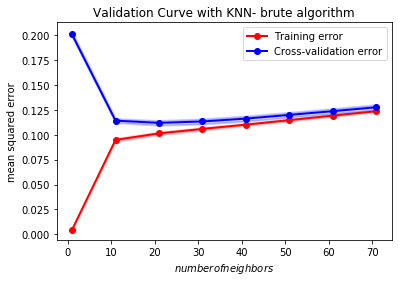

In [37]:
plt.title("Validation Curve with KNN- brute algorithm")
plt.xlabel("$number of neighbors$")
plt.ylabel("mean squared error")

lw = 2
plt.plot(param_range_2, train_scores_mean_validation_2,'o-', label="Training error",
             color="red", lw=lw)
plt.fill_between(param_range_2, train_scores_mean_validation_2 - train_scores_std_validation_2,
                 train_scores_mean_validation_2 + train_scores_std_validation_2, alpha=0.2,
                 color="red", lw=lw)
plt.plot(param_range_2, test_scores_mean_validation_2,'o-', label="Cross-validation error",
             color="blue", lw=lw)
plt.fill_between(param_range_2, test_scores_mean_validation_2 - test_scores_std_validation_2,
                 test_scores_mean_validation_2 + test_scores_std_validation_2, alpha=0.2,
                 color="blue", lw=lw)
plt.legend(loc="best")
plt.savefig('valcurvedetail22.png',dpi=300)

### learning curve

In [38]:
from sklearn.model_selection import learning_curve

In [39]:
%%time
N_learning_2 = 100000
# x and y for learning curve
x_train_learning_curve_2, y_train_learning_curve_2 = sample(N_learning_2,mesh_theta,mesh_phi)

Wall time: 1min


In [40]:
train_sizes_2 = np.linspace(.1, 1.0, 5)
learning_curve_2 = KNeighborsRegressor(n_neighbors=20, algorithm='brute', metric='minkowski', metric_params=None)

In [41]:
%%time
train_sizes_learning_curve_2, train_scores_learning_curve_2, test_scores_learning_curve_2, fit_times_learning_curve_2, score_times_learning_curve_2 = learning_curve(learning_curve_2, x_train_learning_curve_2, y_train_learning_curve_2, cv=2, train_sizes=train_sizes_2,
                       scoring="neg_mean_squared_error", return_times=True)

Wall time: 27min 45s


In [42]:
train_scores_mean_learning_curve_2 = -np.mean(train_scores_learning_curve_2, axis=1)
train_scores_std_learning_curve_2 = np.std(train_scores_learning_curve_2, axis=1)
test_scores_mean_learning_curve_2 = -np.mean(test_scores_learning_curve_2, axis=1)
test_scores_std_learning_curve_2 = np.std(test_scores_learning_curve_2, axis=1)
fit_times_mean_learning_curve_2 = np.mean(fit_times_learning_curve_2, axis=1)
fit_times_std_learning_curve_2 = np.std(fit_times_learning_curve_2, axis=1)

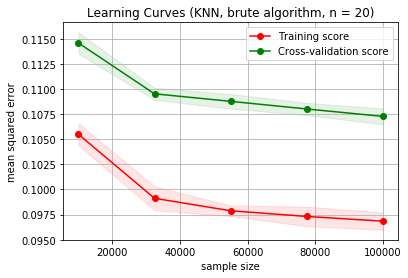

In [50]:
train_sizes_2 = np.linspace(.1, 1.0, 5) * N_learning_2
plt.grid()
plt.fill_between(train_sizes_2, train_scores_mean_learning_curve_2 - train_scores_std_learning_curve_2,
                         train_scores_mean_learning_curve_2 + train_scores_std_learning_curve_2, alpha=0.1,
                         color="r")
plt.fill_between(train_sizes_2, test_scores_mean_learning_curve_2 - test_scores_std_learning_curve_2,
                         test_scores_mean_learning_curve_2 + test_scores_std_learning_curve_2, alpha=0.1,
                         color="g")
plt.plot(train_sizes_2, train_scores_mean_learning_curve_2, 'o-', color="r",
                 label="Training score")
plt.plot(train_sizes_2, test_scores_mean_learning_curve_2, 'o-', color="g",
                 label="Cross-validation score")
plt.legend(loc="best")
plt.xlabel('sample size')
plt.ylabel('mean squared error')
plt.title(r"Learning Curves (KNN, brute algorithm, n = 20)")
plt.savefig('learningcurve22.png',dpi=300)

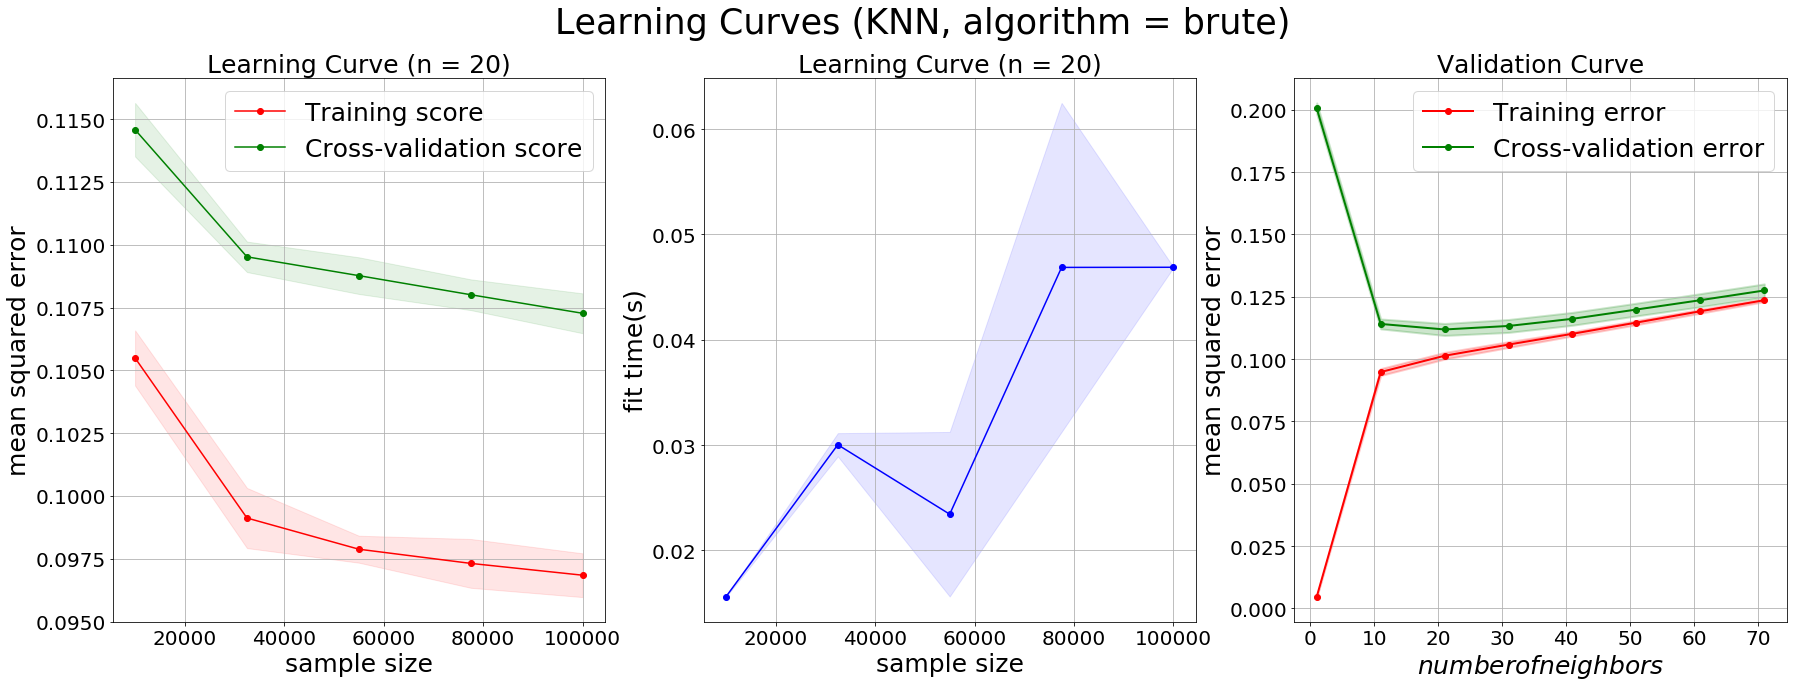

In [157]:
train_sizes_2 = np.linspace(.1, 1.0, 5) * 100000

fig, (ax1, ax3, ax2) = plt.subplots(1, 3, figsize=(30,10))
# Plot learning curve
ax1.grid()
ax1.fill_between(train_sizes_2, train_scores_mean_learning_curve_2 - train_scores_std_learning_curve_2,
                         train_scores_mean_learning_curve_2 + train_scores_std_learning_curve_2, alpha=0.1,
                         color="r")
ax1.fill_between(train_sizes_2, test_scores_mean_learning_curve_2 - test_scores_std_learning_curve_2,
                         test_scores_mean_learning_curve_2 + test_scores_std_learning_curve_2, alpha=0.1,
                         color="g")
ax1.plot(train_sizes_2, train_scores_mean_learning_curve_2, 'o-', color="r",
                 label="Training score")
ax1.plot(train_sizes_2, test_scores_mean_learning_curve_2, 'o-', color="g",
                 label="Cross-validation score")
ax1.legend(loc="best")
ax1.set_xlabel("sample size")
ax1.set_ylabel("mean squared error")
ax1.set_title(r"Learning Curve (n = 20)")

ax3.grid()
ax3.fill_between(train_sizes_2, fit_times_mean_learning_curve_2 - fit_times_std_learning_curve_2,
                         fit_times_mean_learning_curve_2 + fit_times_std_learning_curve_2, alpha=0.1,
                         color="b")
ax3.plot(train_sizes_2, fit_times_mean_learning_curve_2, 'o-', color="b")
ax3.set_xlabel("sample size")
ax3.set_ylabel("fit time(s)")
ax3.set_title(r"Learning Curve (n = 20)")



ax2.grid()
ax2.set_title("Validation Curve")
ax2.set_xlabel(r"$number of neighbors$")
ax2.set_ylabel("mean squared error")
lw = 2
ax2.plot(param_range_2, train_scores_mean_validation_2,'o-', label="Training error",
             color="red", lw=lw)
ax2.fill_between(param_range_2, train_scores_mean_validation_2 - train_scores_std_validation_2,
                 train_scores_mean_validation_2+ train_scores_std_validation_2, alpha=0.2,
                 color="red", lw=lw)
ax2.plot(param_range_2, test_scores_mean_validation_2,'o-', label="Cross-validation error",
             color="green", lw=lw)
ax2.fill_between(param_range_2, test_scores_mean_validation_2 - test_scores_std_validation_2,
                 test_scores_mean_validation_2 + test_scores_std_validation_2, alpha=0.2,
                 color="green", lw=lw)
ax2.legend(loc="best")

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rc('axes',labelsize=25)
plt.rc('axes',titlesize=25)
plt.rc('figure',titlesize=35)
plt.rc('legend',fontsize=25)

fig.suptitle(r"Learning Curves (KNN, algorithm = brute)")
plt.savefig('knncurves22v.png',dpi=300)

In [111]:
np.save('train_sizes_2',train_sizes_2)
np.save('train_scores_mean_learning_curve_2',train_scores_mean_learning_curve_2)
np.save('train_scores_std_learning_curve_2',train_scores_std_learning_curve_2)
np.save('test_scores_mean_learning_curve_2',test_scores_mean_learning_curve_2)
np.save('test_scores_std_learning_curve_2',test_scores_std_learning_curve_2)
np.save('fit_times_mean_learning_curve_2',fit_times_mean_learning_curve_2)
np.save('fit_times_std_learning_curve_2',fit_times_std_learning_curve_2)
np.save('param_range_2',param_range_2)
np.save('train_scores_mean_validation_2',train_scores_mean_validation_2)
np.save('train_scores_std_validation_2',train_scores_std_validation_2)
np.save('test_scores_mean_validation_2',test_scores_mean_validation_2)
np.save('test_scores_std_validation_2',test_scores_std_validation_2)

### final fitting with best parameters and sample size

In [246]:
best_model_2 = KNeighborsRegressor(n_neighbors=20, algorithm='brute', metric='minkowski', metric_params=None)
best_sample_size_2 = 100000

In [247]:
%%time
#train set
x_train_2, y_train_2 = sample(best_sample_size_2,mesh_theta,mesh_phi)
print('train samples shape' ,x_train_2.shape, y_train_2.shape)
#test set
x_test_2, y_test_2 = sample(best_sample_size_2,mesh_theta,mesh_phi)
print('test samples shape' ,x_train_2.shape, y_train_2.shape)

train samples shape (100000, 200) (100000,)
test samples shape (100000, 200) (100000,)
Wall time: 3min 1s


In [248]:
%%time
best_model_2.fit(x_train_2, y_train_2)
print('fit time')

fit time
Wall time: 1.26 s


In [265]:
%%time
y_predict_2 = best_model_2.predict(x_test_2)
print('predict time')

predict time
Wall time: 12min 38s


In [266]:
%%time
MSE_2 = mean_squared_error(y_test_2, y_predict_2)
print('MSE:' ,MSE_2)

MSE: 0.1044680682599717
Wall time: 1.99 ms


# model 3: KernelRidge

In [162]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error

In [ ]:
#KernelRidge(alpha=1, kernel='linear', gamma=None)

In [42]:
#the intersection matrix dimension
mesh_theta,mesh_phi = 10, 20 
#meshgrid
phi_s,theta_s = space(mesh_theta,mesh_phi)

In [165]:
#generating train samples for model with one output
N_sample_3 = 10000 #number of cones
N_feature_3 = mesh_theta * mesh_phi #intersection matrix
N_outputs_3 = 1 # theta_cs as output
N_test_3 = 10000
print(N_sample_3,' samples with ',N_feature_3,'features')

10000  samples with  200 features


### Grid search to find the kernel and gamma

In [44]:
from sklearn.model_selection import GridSearchCV

In [49]:
%%time
# x and y for gridsearch
x_train_gridsearch_3, y_train_gridsearch_3 = sample(N_sample_3,mesh_theta,mesh_phi)

Wall time: 6.59 s


In [96]:
# different parameters 
parameters = [{'kernel': ['laplacian'], 'gamma': [0,0.1,0.2],
                     'alpha': [0.01,0.1,1]}]

In [91]:
# different parameters 
parameters = [{'kernel': ['rbf'], 'gamma': [0,0.1],
                     'alpha': [0.1,1,10]}]

In [97]:
%%time
print("# Tuning hyper-parameters for neg_mean_squared_error")
print()

gridsearch_3 = GridSearchCV(KernelRidge(), parameters, scoring= 'neg_mean_squared_error', cv=3)
gridsearch_3.fit(x_train_gridsearch_3, y_train_gridsearch_3)

print("Best parameters set found on development set:")
print()
print(gridsearch_3.best_params_)
print()
print("Grid scores on development set:")
print()
means = gridsearch_3.cv_results_['mean_test_score']
stds = gridsearch_3.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gridsearch_3.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()


# Tuning hyper-parameters for neg_mean_squared_error

Best parameters set found on development set:

{'alpha': 0.1, 'gamma': 0.1, 'kernel': 'laplacian'}

Grid scores on development set:

-0.208 (+/-0.006) for {'alpha': 0.01, 'gamma': 0, 'kernel': 'laplacian'}
-0.149 (+/-0.004) for {'alpha': 0.01, 'gamma': 0.1, 'kernel': 'laplacian'}
-0.306 (+/-0.022) for {'alpha': 0.01, 'gamma': 0.2, 'kernel': 'laplacian'}
-0.208 (+/-0.006) for {'alpha': 0.1, 'gamma': 0, 'kernel': 'laplacian'}
-0.136 (+/-0.006) for {'alpha': 0.1, 'gamma': 0.1, 'kernel': 'laplacian'}
-0.309 (+/-0.024) for {'alpha': 0.1, 'gamma': 0.2, 'kernel': 'laplacian'}
-0.208 (+/-0.006) for {'alpha': 1, 'gamma': 0, 'kernel': 'laplacian'}
-0.147 (+/-0.009) for {'alpha': 1, 'gamma': 0.1, 'kernel': 'laplacian'}
-0.379 (+/-0.031) for {'alpha': 1, 'gamma': 0.2, 'kernel': 'laplacian'}

Wall time: 5min 38s


In [98]:
import pandas as pd
gridsearch_df_3 = pd.DataFrame(gridsearch_3.cv_results_)

In [99]:
grid_laplacian = gridsearch_df_3.drop(columns=['mean_score_time','std_score_time','params','split0_test_score','split1_test_score','split2_test_score'])

In [95]:
grid_rbf

,mean_fit_time,std_fit_time,param_alpha,param_gamma,param_kernel,mean_test_score,std_test_score,rank_test_score
0,5.026530,0.577009,0.1,0,rbf,-0.208367,0.002790,4
1,5.779177,0.389026,0.1,0.1,rbf,-0.136497,0.002912,1
2,6.479283,0.500747,1,0,rbf,-0.208367,0.002794,3
3,5.672025,0.155566,1,0.1,rbf,-0.146922,0.004319,2
4,5.124259,0.557851,10,0,rbf,-0.208368,0.002831,5
5,5.148460,0.149797,10,0.1,rbf,-0.274145,0.010473,6


In [100]:
grid_laplacian

,mean_fit_time,std_fit_time,param_alpha,param_gamma,param_kernel,mean_test_score,std_test_score,rank_test_score
0,9.251235,3.864240,0.01,0,laplacian,-0.208367,0.002790,6
1,9.163653,0.401344,0.01,0.1,laplacian,-0.148834,0.002250,3
2,13.417797,7.111224,0.01,0.2,laplacian,-0.306232,0.011070,7
3,7.694922,0.252777,0.1,0,laplacian,-0.208367,0.002790,5
4,8.105716,0.545487,0.1,0.1,laplacian,-0.136497,0.002912,1
5,7.508973,0.367164,0.1,0.2,laplacian,-0.309242,0.011924,8
6,7.036235,0.386131,1,0,laplacian,-0.208367,0.002794,4
7,7.788314,0.376734,1,0.1,laplacian,-0.146922,0.004319,2
8,7.910065,0.126415,1,0.2,laplacian,-0.378672,0.015501,9


### Tuning the parameter(alpha) of KernelRidge with validation curve

In [163]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import validation_curve

In [166]:
%%time
# x and y for validation curve
x_train_validation_curve_3, y_train_validation_curve_3 = sample(N_sample_3,mesh_theta,mesh_phi)
x_test_validation_curve_3, y_test_validation_curve_3 = sample(N_sample_3,mesh_theta,mesh_phi)

Wall time: 11.8 s


In [167]:
param_range_3 = np.logspace(-3, 3, 5)
validation_curve_3 = KernelRidge(kernel='rbf', gamma=0.1)

In [168]:
%%time
train_scores_validation_3, test_scores_validation_3 = validation_curve(validation_curve_3, x_train_validation_curve_3, y_train_validation_curve_3, param_name="alpha", param_range=param_range_3,
    scoring="neg_mean_squared_error", cv=3)

Wall time: 2min 58s


In [169]:
train_scores_mean_validation_3 = -np.mean(train_scores_validation_3, axis=1)
train_scores_std_validation_3 = np.std(train_scores_validation_3, axis=1)
test_scores_mean_validation_3 = -np.mean(test_scores_validation_3, axis=1)
test_scores_std_validation_3 = np.std(test_scores_validation_3, axis=1)

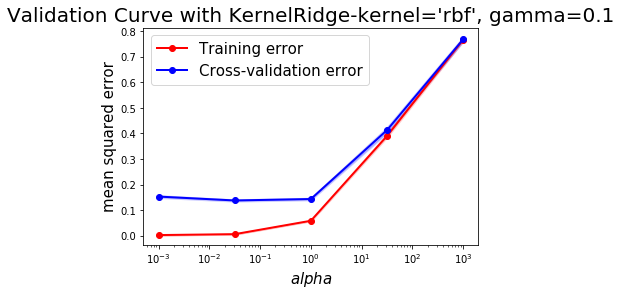

In [170]:
plt.title("Validation Curve with KernelRidge-kernel='rbf', gamma=0.1")
plt.xlabel("$alpha$")
plt.ylabel("mean squared error")

lw = 2
plt.semilogx(param_range_3, train_scores_mean_validation_3,'o-', label="Training error",
             color="red", lw=lw)
plt.fill_between(param_range_3, train_scores_mean_validation_3 - train_scores_std_validation_3,
                 train_scores_mean_validation_3 + train_scores_std_validation_3, alpha=0.2,
                 color="red", lw=lw)
plt.semilogx(param_range_3, test_scores_mean_validation_3,'o-', label="Cross-validation error",
             color="blue", lw=lw)
plt.fill_between(param_range_3, test_scores_mean_validation_3 - test_scores_std_validation_3,
                 test_scores_mean_validation_3 + test_scores_std_validation_3, alpha=0.2,
                 color="blue", lw=lw)
plt.legend(loc="best")
plt.savefig('valcurve33.png',dpi=300)

In [109]:
param_range_3_detail = np.linspace(1, 10, 5)
validation_curve_3_detail = KernelRidge(kernel='rbf', gamma=0.1)

In [110]:
%%time
train_scores_validation_3_detail, test_scores_validation_3_detail = validation_curve(validation_curve_3, x_train_validation_curve_3, y_train_validation_curve_3, param_name="alpha", param_range=param_range_3_detail,
    scoring="neg_mean_squared_error", cv=3)

Wall time: 2min 47s


In [111]:
train_scores_mean_validation_3_detail = -np.mean(train_scores_validation_3_detail, axis=1)
train_scores_std_validation_3_detail = np.std(train_scores_validation_3_detail, axis=1)
test_scores_mean_validation_3_detail = -np.mean(test_scores_validation_3_detail, axis=1)
test_scores_std_validation_3_detail = np.std(test_scores_validation_3_detail, axis=1)

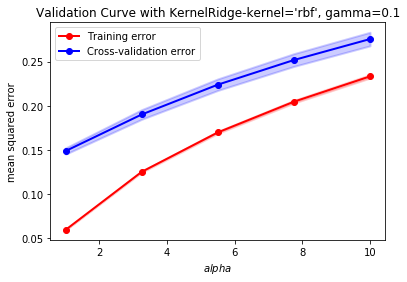

In [119]:
plt.title("Validation Curve with KernelRidge-kernel='rbf', gamma=0.1")
plt.xlabel("$alpha$")
plt.ylabel("mean squared error")

lw = 2
plt.plot(param_range_3_detail, train_scores_mean_validation_3_detail,'o-', label="Training error",
             color="red", lw=lw)
plt.fill_between(param_range_3_detail, train_scores_mean_validation_3_detail - train_scores_std_validation_3_detail,
                 train_scores_mean_validation_3_detail + train_scores_std_validation_3_detail, alpha=0.2,
                 color="red", lw=lw)
plt.plot(param_range_3_detail, test_scores_mean_validation_3_detail,'o-', label="Cross-validation error",
             color="blue", lw=lw)
plt.fill_between(param_range_3_detail, test_scores_mean_validation_3_detail - test_scores_std_validation_3_detail,
                 test_scores_mean_validation_3_detail + test_scores_std_validation_3_detail, alpha=0.2,
                 color="blue", lw=lw)
plt.legend(loc="best")
plt.savefig('valcurve_detail3.png',dpi=300)

### learning curve

In [171]:
from sklearn.model_selection import learning_curve

In [172]:
%%time
N_learning_3 = 50000
# x and y for learning curve
x_train_learning_curve_3, y_train_learning_curve_3 = sample(N_learning_3,mesh_theta,mesh_phi)
#x_test_learning_curve_1, y_test_learning_curve_1 = sample(N_learning_1,mesh_theta,mesh_phi)

Wall time: 36.9 s


In [173]:
train_sizes_3 = np.linspace(.1, 1.0, 5)
learning_curve_3 = KernelRidge(alpha = 10 ,kernel='rbf', gamma=0.1)

In [174]:
%%time
train_sizes_learning_curve_3, train_scores_learning_curve_3, test_scores_learning_curve_3, fit_times_learning_curve_3, score_times_learning_curve_3 = learning_curve(learning_curve_3, x_train_learning_curve_3, y_train_learning_curve_3, cv=2, train_sizes=train_sizes_3,
                       scoring="neg_mean_squared_error", return_times=True)

Wall time: 16min 49s


In [175]:
train_scores_mean_learning_curve_3 = -np.mean(train_scores_learning_curve_3, axis=1)
train_scores_std_learning_curve_3 = np.std(train_scores_learning_curve_3, axis=1)
test_scores_mean_learning_curve_3 = -np.mean(test_scores_learning_curve_3, axis=1)
test_scores_std_learning_curve_3 = np.std(test_scores_learning_curve_3, axis=1)
fit_times_mean_learning_curve_3 = np.mean(fit_times_learning_curve_3, axis=1)
fit_times_std_learning_curve_3 = np.std(fit_times_learning_curve_3, axis=1)

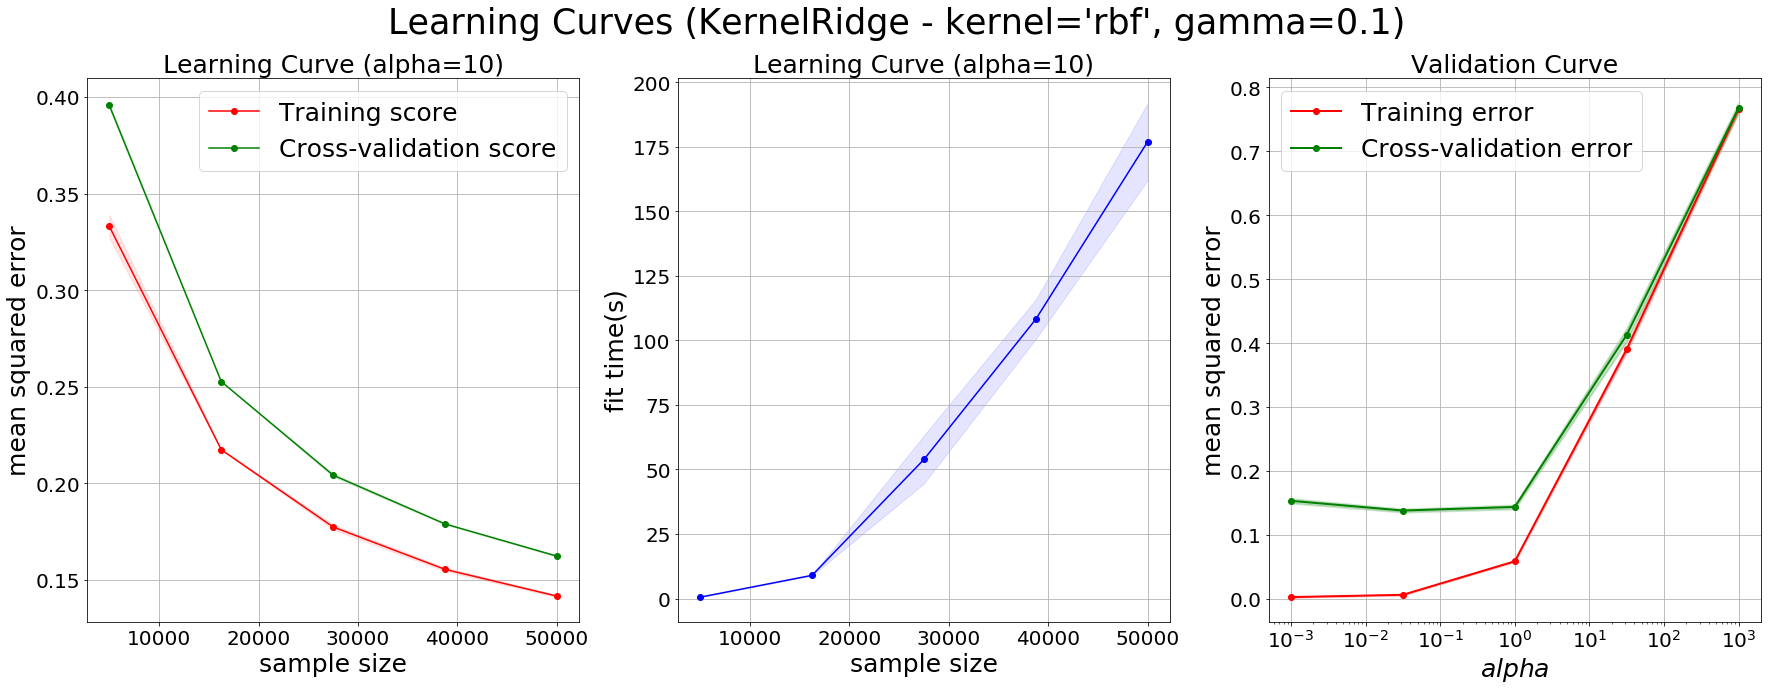

In [177]:
train_sizes_3 = np.linspace(.1, 1.0, 5) * N_learning_3

fig, (ax1, ax3, ax2) = plt.subplots(1, 3, figsize=(30,10))
# Plot learning curve
ax1.grid()
ax1.fill_between(train_sizes_3, train_scores_mean_learning_curve_3 - train_scores_std_learning_curve_3,
                         train_scores_mean_learning_curve_3 + train_scores_std_learning_curve_3, alpha=0.1,
                         color="r")
ax1.fill_between(train_sizes_3, test_scores_mean_learning_curve_3 - test_scores_std_learning_curve_3,
                         test_scores_mean_learning_curve_3 + test_scores_std_learning_curve_3, alpha=0.1,
                         color="g")
ax1.plot(train_sizes_3, train_scores_mean_learning_curve_3, 'o-', color="r",
                 label="Training score")
ax1.plot(train_sizes_3, test_scores_mean_learning_curve_3, 'o-', color="g",
                 label="Cross-validation score")
ax1.legend(loc="best")
ax1.set_xlabel("sample size")
ax1.set_ylabel("mean squared error")
ax1.set_title(r"Learning Curve (alpha=10)")


ax3.grid()
ax3.fill_between(train_sizes_3, fit_times_mean_learning_curve_3 - fit_times_std_learning_curve_3,
                         fit_times_mean_learning_curve_3 + fit_times_std_learning_curve_3, alpha=0.1,
                         color="b")
ax3.plot(train_sizes_3, fit_times_mean_learning_curve_3, 'o-', color="b")
ax3.set_xlabel("sample size")
ax3.set_ylabel("fit time(s)")
ax3.set_title(r"Learning Curve (alpha=10)")



ax2.grid()
ax2.set_title("Validation Curve")
ax2.set_xlabel(r"$alpha$")
ax2.set_ylabel("mean squared error")
lw = 2
ax2.semilogx(param_range_3, train_scores_mean_validation_3,'o-', label="Training error",
             color="red", lw=lw)
ax2.fill_between(param_range_3, train_scores_mean_validation_3 - train_scores_std_validation_3,
                 train_scores_mean_validation_3+ train_scores_std_validation_3, alpha=0.2,
                 color="red", lw=lw)
ax2.semilogx(param_range_3, test_scores_mean_validation_3,'o-', label="Cross-validation error",
             color="green", lw=lw)
ax2.fill_between(param_range_3, test_scores_mean_validation_3 - test_scores_std_validation_3,
                 test_scores_mean_validation_3 + test_scores_std_validation_3, alpha=0.2,
                 color="green", lw=lw)
ax2.legend(loc="best")

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rc('axes',labelsize=25)
plt.rc('axes',titlesize=25)
plt.rc('figure',titlesize=35)
plt.rc('legend',fontsize=25)

fig.suptitle(r"Learning Curves (KernelRidge - kernel='rbf', gamma=0.1)")
plt.savefig('kernelridgecurves33v.png',dpi=300)

In [178]:
np.save('train_sizes_3',train_sizes_3)
np.save('train_scores_mean_learning_curve_3',train_scores_mean_learning_curve_3)
np.save('train_scores_std_learning_curve_3',train_scores_std_learning_curve_3)
np.save('test_scores_mean_learning_curve_3',test_scores_mean_learning_curve_3)
np.save('test_scores_std_learning_curve_3',test_scores_std_learning_curve_3)
np.save('fit_times_mean_learning_curve_3',fit_times_mean_learning_curve_3)
np.save('fit_times_std_learning_curve_3',fit_times_std_learning_curve_3)
np.save('param_range_3',param_range_3)
np.save('train_scores_mean_validation_3',train_scores_mean_validation_3)
np.save('train_scores_std_validation_3',train_scores_std_validation_3)
np.save('test_scores_mean_validation_3',test_scores_mean_validation_3)
np.save('test_scores_std_validation_3',test_scores_std_validation_3)

### final fitting with best parameters and sample size

In [82]:
best_model_3 = KernelRidge(alpha = 10,kernel='rbf', gamma=0.1)
best_sample_size_3 = 10000

In [83]:
%%time
#train set
x_train_3, y_train_3 = sample(best_sample_size_3,mesh_theta,mesh_phi)
print('train samples shape' ,x_train_3.shape, y_train_3.shape)
#test set
x_test_3, y_test_3 = sample(best_sample_size_3,mesh_theta,mesh_phi)
print('test samples shape' ,x_train_3.shape, y_train_3.shape)

train samples shape (10000, 200) (10000,)
test samples shape (10000, 200) (10000,)
Wall time: 18.6 s


In [84]:
%%time
best_model_3.fit(x_train_3, y_train_3)
print('fit time')

fit time
Wall time: 35.9 s


In [88]:
%%time
y_predict_3 = best_model_3.predict(x_test_3)
print('predict time')

predict time
Wall time: 9.11 s


In [89]:
%%time
MSE_3 = mean_squared_error(y_test_3, y_predict_3)
print('MSE:' ,MSE_3)

MSE: 0.23314696178917374
Wall time: 6.98 ms


# model 4: LinearRegression

In [93]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [10]:
#the intersection matrix dimension
mesh_theta,mesh_phi = 10, 20 
#meshgrid
phi_s,theta_s = space(mesh_theta,mesh_phi)

In [11]:
#generating train samples for model with one output
N_sample_4 = 50000 #number of cones
N_feature_4 = mesh_theta * mesh_phi #intersection matrix
N_outputs_4 = 1 # theta_cs as output
N_test_4 = 50000
print(N_sample_4,' samples with ',N_feature_4,'features')

50000  samples with  200 features


In [12]:
#LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)

### Grid search to find the best fit_intercept and normalize

In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
%%time
# x and y for gridsearch
x_train_gridsearch_4, y_train_gridsearch_4 = sample(N_sample_4,mesh_theta,mesh_phi)

Wall time: 38.9 s


In [15]:
# different parameters 
parameters = [{'fit_intercept': ['True','False'] , 'normalize': ['True','False']}]

In [16]:
%%time
print("# Tuning hyper-parameters for neg_mean_squared_error")
print()

gridsearch_4 = GridSearchCV(LinearRegression(), parameters, scoring= 'neg_mean_squared_error', cv=6)
gridsearch_4.fit(x_train_gridsearch_4, y_train_gridsearch_4)

print("Best parameters set found on development set:")
print()
print(gridsearch_4.best_params_)
print()
print("Grid scores on development set:")
print()
means = gridsearch_4.cv_results_['mean_test_score']
stds = gridsearch_4.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gridsearch_4.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

# Tuning hyper-parameters for neg_mean_squared_error

Best parameters set found on development set:

{'fit_intercept': 'True', 'normalize': 'True'}

Grid scores on development set:

-0.128 (+/-0.003) for {'fit_intercept': 'True', 'normalize': 'True'}
-0.128 (+/-0.003) for {'fit_intercept': 'True', 'normalize': 'False'}
-0.128 (+/-0.003) for {'fit_intercept': 'False', 'normalize': 'True'}
-0.128 (+/-0.003) for {'fit_intercept': 'False', 'normalize': 'False'}

Wall time: 10.2 s


In [17]:
import pandas as pd
gridsearch_df_4 = pd.DataFrame(gridsearch_4.cv_results_)
gridsearch_df_4 = gridsearch_df_4.drop(columns=['mean_score_time','std_score_time','params','split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score','split5_test_score'])

In [18]:
gridsearch_df_4

,mean_fit_time,std_fit_time,param_fit_intercept,param_normalize,mean_test_score,std_test_score,rank_test_score
0,0.371726,0.036817,True,True,-0.128152,0.001361,1
1,0.358807,0.035111,True,False,-0.128152,0.001361,1
2,0.372274,0.010500,False,True,-0.128152,0.001361,1
3,0.437413,0.051469,False,False,-0.128152,0.001361,1


### learning curve

In [90]:
from sklearn.model_selection import learning_curve

In [91]:
%%time
N_learning_4 = 500000
# x and y for learning curve
x_train_learning_curve_4, y_train_learning_curve_4 = sample(N_learning_4,mesh_theta,mesh_phi)

Wall time: 5min 45s


In [94]:
train_sizes_4 = np.linspace(.1, 1.0, 5)
learning_curve_4 = LinearRegression(fit_intercept=False, copy_X=True, n_jobs=None)

In [95]:
%%time
train_sizes_learning_curve_4, train_scores_learning_curve_4, test_scores_learning_curve_4, fit_times_learning_curve_4, score_times_learning_curve_4 = learning_curve(learning_curve_4, x_train_learning_curve_4, y_train_learning_curve_4, cv=5, train_sizes=train_sizes_4,
                       scoring="neg_mean_squared_error", return_times=True)

Wall time: 1min 21s


In [96]:
train_scores_mean_learning_curve_4 = -np.mean(train_scores_learning_curve_4, axis=1)
train_scores_std_learning_curve_4 = np.std(train_scores_learning_curve_4, axis=1)
test_scores_mean_learning_curve_4 = -np.mean(test_scores_learning_curve_4, axis=1)
test_scores_std_learning_curve_4 = np.std(test_scores_learning_curve_4, axis=1)
fit_times_mean_learning_curve_4 = np.mean(fit_times_learning_curve_4, axis=1)
fit_times_std_learning_curve_4 = np.std(fit_times_learning_curve_4, axis=1)

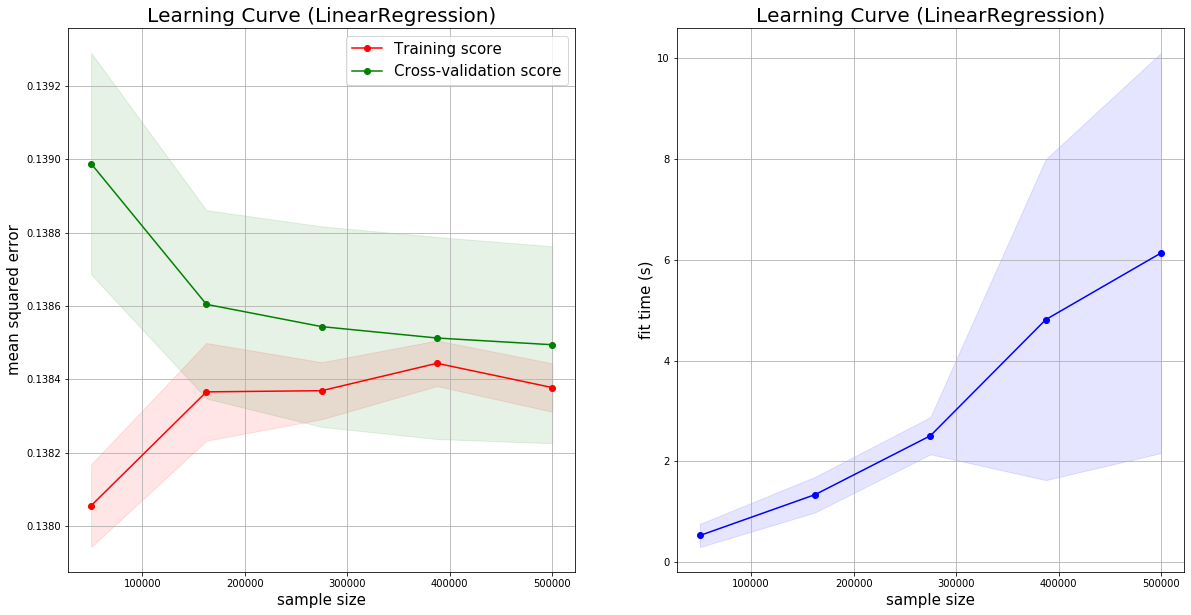

In [160]:
train_sizes_4 = np.linspace(.1, 1.0, 5) * N_learning_4

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(20,10))
# Plot learning curve
ax1.grid()
ax1.fill_between(train_sizes_4, train_scores_mean_learning_curve_4 - train_scores_std_learning_curve_4,
                         train_scores_mean_learning_curve_4 + train_scores_std_learning_curve_4, alpha=0.1,
                         color="r")
ax1.fill_between(train_sizes_4, test_scores_mean_learning_curve_4 - test_scores_std_learning_curve_4,
                         test_scores_mean_learning_curve_4 + test_scores_std_learning_curve_4, alpha=0.1,
                         color="g")
ax1.plot(train_sizes_4, train_scores_mean_learning_curve_4, 'o-', color="r",
                 label="Training score")
ax1.plot(train_sizes_4, test_scores_mean_learning_curve_4, 'o-', color="g",
                 label="Cross-validation score")
ax1.legend(loc="best")
ax1.set_xlabel("sample size")
ax1.set_ylabel("mean squared error")
ax1.set_title(r"Learning Curve (LinearRegression)")


ax3.grid()
ax3.fill_between(train_sizes_4, fit_times_mean_learning_curve_4 - fit_times_std_learning_curve_4,
                         fit_times_mean_learning_curve_4 + fit_times_std_learning_curve_4, alpha=0.1,
                         color="blue")
ax3.plot(train_sizes_4, fit_times_mean_learning_curve_4, 'o-', color="blue")
ax3.set_xlabel("sample size")
ax3.set_ylabel("fit time (s)")
ax3.set_title(r"Learning Curve (LinearRegression)")


plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
plt.rc('axes',labelsize=15)
plt.rc('axes',titlesize=20)
plt.rc('figure',titlesize=30)
plt.rc('legend',fontsize=15)

plt.savefig('linearregressioncurves44v.png',dpi=300)

In [114]:
np.save('train_sizes_4',train_sizes_4)
np.save('train_scores_mean_learning_curve_4',train_scores_mean_learning_curve_4)
np.save('train_scores_std_learning_curve_4',train_scores_std_learning_curve_4)
np.save('test_scores_mean_learning_curve_4',test_scores_mean_learning_curve_4)
np.save('test_scores_std_learning_curve_4',test_scores_std_learning_curve_4)
np.save('fit_times_mean_learning_curve_4',fit_times_mean_learning_curve_4)
np.save('fit_times_std_learning_curve_4',fit_times_std_learning_curve_4)

### final fitting with best parameters and sample size

In [36]:
best_model_4 = LinearRegression(fit_intercept=False, copy_X=True, n_jobs=None)
best_sample_size_4 = 400000

In [37]:
%%time
#train set
x_train_4, y_train_4 = sample(best_sample_size_4,mesh_theta,mesh_phi)
print('train samples shape' ,x_train_4.shape, y_train_4.shape)
#test set
x_test_4, y_test_4 = sample(best_sample_size_4,mesh_theta,mesh_phi)
print('test samples shape' ,x_train_4.shape, y_train_4.shape)

train samples shape (400000, 200) (400000,)
test samples shape (400000, 200) (400000,)
Wall time: 8min 13s


In [38]:
%%time
best_model_4.fit(x_train_4, y_train_4)
print('fit time')

fit time
Wall time: 5.83 s


In [39]:
%%time
y_predict_4 = best_model_4.predict(x_test_4)
print('predict time')

predict time
Wall time: 2.12 s


In [40]:
%%time
MSE_4 = mean_squared_error(y_test_4, y_predict_4)
print('MSE:' ,MSE_4)

MSE: 0.13874022055386903
Wall time: 7.98 ms


# mpdel 5: DecisionTreeRegressor

In [185]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [186]:
#the intersection matrix dimension
mesh_theta,mesh_phi = 10, 20 
#meshgrid
phi_s,theta_s = space(mesh_theta,mesh_phi)

In [188]:
#generating train samples for model with one output
N_sample_5 = 10000 #number of cones
N_feature_5 = mesh_theta * mesh_phi #intersection matrix
N_outputs_5 = 1 # theta_cs as output
N_test_5 = 10000
print(N_sample_5,' samples with ',N_feature_5,'features')

10000  samples with  200 features


In [ ]:
#DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, presort='deprecated', ccp_alpha=0.0)

### Grid search to find the best splitter and min_samples_split and min_samples_leaf

In [189]:
from sklearn.model_selection import GridSearchCV

In [190]:
# DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, min_samples_split=2, 
#                       min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
#                       random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#                       min_impurity_split=None, presort='deprecated', ccp_alpha=0.0)

In [191]:
%%time
# x and y for gridsearch
x_train_gridsearch_5, y_train_gridsearch_5 = sample(N_sample_5,mesh_theta,mesh_phi)
#y_train_gridsearch_2 = y_train_gridsearch_2.astype('float')
#x_test_gridsearch_2, y_test_gridsearch_2 = sample(N_sample_2,mesh_theta,mesh_phi)
#y_test_gridsearch_2 = y_test_gridsearch_2.astype('float')

Wall time: 5.81 s


In [246]:
# different parameters 
parameters = [{'splitter': ['best','random'], 'max_depth': [1,3,5,10,500] , 'min_samples_split': [2,3,4,20] , 'min_samples_leaf': [1,2,5]}]

In [247]:
%%time
print("# Tuning hyper-parameters for neg_mean_squared_error")
print()

gridsearch_5 = GridSearchCV(DecisionTreeRegressor(), parameters, scoring= 'neg_mean_squared_error', cv=5)
gridsearch_5.fit(x_train_gridsearch_5, y_train_gridsearch_5)

print("Best parameters set found on development set:")
print()
print(gridsearch_5.best_params_)
print()
print("Grid scores on development set:")
print()
means = gridsearch_5.cv_results_['mean_test_score']
stds = gridsearch_5.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gridsearch_5.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

# Tuning hyper-parameters for neg_mean_squared_error

Best parameters set found on development set:

{'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20, 'splitter': 'random'}

Grid scores on development set:

-0.198 (+/-0.007) for {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
-0.198 (+/-0.007) for {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
-0.198 (+/-0.007) for {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'best'}
-0.198 (+/-0.007) for {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'random'}
-0.198 (+/-0.007) for {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'best'}
-0.198 (+/-0.007) for {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'random'}
-0.198 (+/-0.007) for {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 20, 'splitter': 'best'}
-0.198 (+/-0.007) for {'max_

In [198]:
import pandas as pd
gridsearch_df_5 = pd.DataFrame(gridsearch_5.cv_results_)

In [203]:
grid_5 = gridsearch_df_5.drop(columns=['mean_score_time','std_score_time','params','split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score'])

In [204]:
grid_5

,mean_fit_time,std_fit_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_splitter,mean_test_score,std_test_score,rank_test_score
0,0.009987,0.001885,1,1,2,best,-0.198438,0.003619,9
1,0.010970,0.000892,1,1,2,random,-0.198438,0.003619,9
2,0.023144,0.001929,3,1,2,best,-0.180049,0.002645,6
3,0.021144,0.001323,3,1,2,random,-0.180049,0.002645,5
4,0.040697,0.000986,5,1,2,best,-0.162383,0.001491,3
5,0.041121,0.000749,5,1,2,random,-0.162399,0.001448,4
6,0.270810,0.006965,10,1,2,best,-0.151883,0.002441,2
7,0.270215,0.006499,10,1,2,random,-0.151820,0.002370,1
8,0.921532,0.015004,20,1,2,best,-0.197095,0.003990,7
9,0.974021,0.090364,20,1,2,random,-0.197633,0.005434,8


### Tuning the parameter(max_depth) of DecisionTree with validation curve

In [208]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import validation_curve

In [209]:
%%time
# x and y for validation curve
x_train_validation_curve_5, y_train_validation_curve_5 = sample(N_sample_5,mesh_theta,mesh_phi)

Wall time: 5.99 s


In [398]:
param_range_5 = np.logspace(0, 3, 10)
validation_curve_5 = DecisionTreeRegressor(criterion='mse', splitter='random', min_samples_split=45, min_samples_leaf=25)

In [399]:
%%time
train_scores_validation_5, test_scores_validation_5 = validation_curve(validation_curve_5, x_train_validation_curve_5, y_train_validation_curve_5, param_name="max_depth", param_range=param_range_5,
    scoring="neg_mean_squared_error", cv=5)

Wall time: 8.11 s


In [400]:
train_scores_mean_validation_5 = -np.mean(train_scores_validation_5, axis=1)
train_scores_std_validation_5 = np.std(train_scores_validation_5, axis=1)
test_scores_mean_validation_5 = -np.mean(test_scores_validation_5, axis=1)
test_scores_std_validation_5 = np.std(test_scores_validation_5, axis=1)

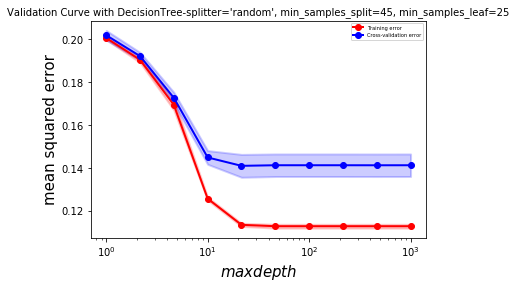

In [401]:
plt.title("Validation Curve with DecisionTree-splitter='random', min_samples_split=45, min_samples_leaf=25")
plt.xlabel("$max depth$")
plt.ylabel("mean squared error")

lw = 2
plt.semilogx(param_range_5, train_scores_mean_validation_5,'o-', label="Training error",
             color="red", lw=lw)
plt.fill_between(param_range_5, train_scores_mean_validation_5 - train_scores_std_validation_5,
                 train_scores_mean_validation_5 + train_scores_std_validation_5, alpha=0.2,
                 color="red", lw=lw)
plt.semilogx(param_range_5, test_scores_mean_validation_5,'o-', label="Cross-validation error",
             color="blue", lw=lw)
plt.fill_between(param_range_5, test_scores_mean_validation_5 - test_scores_std_validation_5,
                 test_scores_mean_validation_5 + test_scores_std_validation_5, alpha=0.2,
                 color="blue", lw=lw)
plt.legend(loc="best")

plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
plt.rc('axes',labelsize=15)
plt.rc('axes',titlesize=10)
plt.rc('figure',titlesize=10)
plt.rc('legend',fontsize=5)

plt.savefig('valcurvedetail55.png',dpi=300)

### learning curve

In [402]:
from sklearn.model_selection import learning_curve

In [432]:
%%time
N_learning_5 = 200000
# x and y for learning curve
x_train_learning_curve_5, y_train_learning_curve_5 = sample(N_learning_5,mesh_theta,mesh_phi)

Wall time: 1min 59s


In [438]:
train_sizes_5 = np.linspace(.1, 1.0, 5)
learning_curve_5 = DecisionTreeRegressor(criterion='mse',max_depth=10, splitter='random', min_samples_split=45, min_samples_leaf=25)

In [439]:
%%time
train_sizes_learning_curve_5, train_scores_learning_curve_5, test_scores_learning_curve_5, fit_times_learning_curve_5, score_times_learning_curve_5 = learning_curve(learning_curve_5, x_train_learning_curve_5, y_train_learning_curve_5, cv=3, train_sizes=train_sizes_5,
                       scoring="neg_mean_squared_error", return_times=True)

Wall time: 50.5 s


In [440]:
train_scores_mean_learning_curve_5 = -np.mean(train_scores_learning_curve_5, axis=1)
train_scores_std_learning_curve_5 = np.std(train_scores_learning_curve_5, axis=1)
test_scores_mean_learning_curve_5 = -np.mean(test_scores_learning_curve_5, axis=1)
test_scores_std_learning_curve_5 = np.std(test_scores_learning_curve_5, axis=1)
fit_times_mean_learning_curve_5 = np.mean(fit_times_learning_curve_5, axis=1)
fit_times_std_learning_curve_5 = np.std(fit_times_learning_curve_5, axis=1)

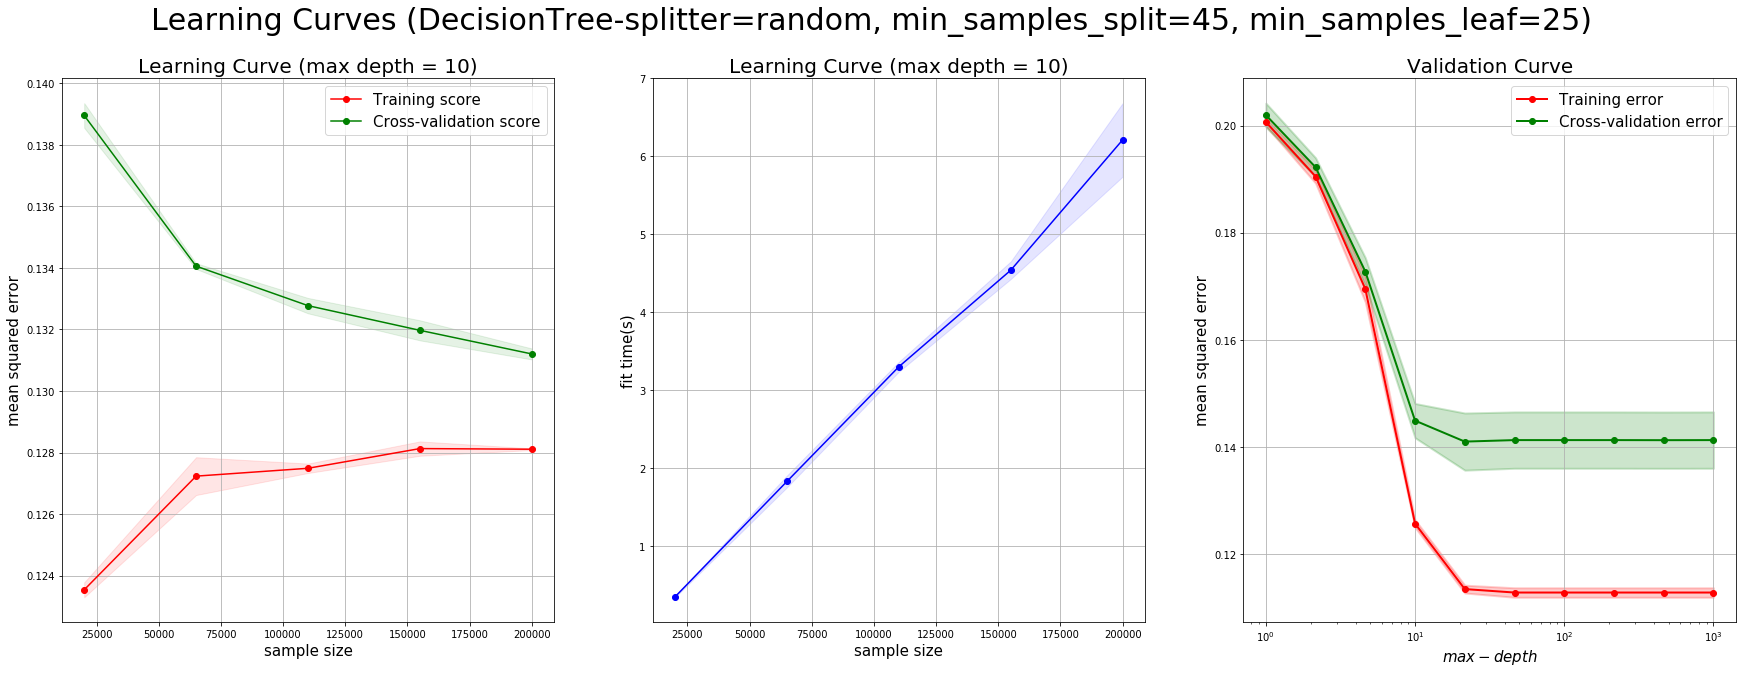

In [443]:
train_sizes_5 = np.linspace(.1, 1.0, 5) * N_learning_5

fig, (ax1, ax3, ax2) = plt.subplots(1, 3, figsize=(30,10))
# Plot learning curve
ax1.grid()
ax1.fill_between(train_sizes_5, train_scores_mean_learning_curve_5 - train_scores_std_learning_curve_5,
                         train_scores_mean_learning_curve_5 + train_scores_std_learning_curve_5, alpha=0.1,
                         color="r")
ax1.fill_between(train_sizes_5, test_scores_mean_learning_curve_5 - test_scores_std_learning_curve_5,
                         test_scores_mean_learning_curve_5 + test_scores_std_learning_curve_5, alpha=0.1,
                         color="g")
ax1.plot(train_sizes_5, train_scores_mean_learning_curve_5, 'o-', color="r",
                 label="Training score")
ax1.plot(train_sizes_5, test_scores_mean_learning_curve_5, 'o-', color="g",
                 label="Cross-validation score")
ax1.legend(loc="best")
ax1.set_xlabel("sample size")
ax1.set_ylabel("mean squared error")
ax1.set_title(r"Learning Curve (max depth = 10)")


ax3.grid()
ax3.fill_between(train_sizes_5, fit_times_mean_learning_curve_5 - fit_times_std_learning_curve_5,
                         fit_times_mean_learning_curve_5 + fit_times_std_learning_curve_5, alpha=0.1,
                         color="b")
ax3.plot(train_sizes_5, fit_times_mean_learning_curve_5, 'o-', color="b")
ax3.set_xlabel("sample size")
ax3.set_ylabel("fit time(s)")
ax3.set_title(r"Learning Curve (max depth = 10)")



ax2.grid()
ax2.set_title("Validation Curve")
ax2.set_xlabel(r"$max-depth$")
ax2.set_ylabel("mean squared error")
lw = 2
ax2.semilogx(param_range_5, train_scores_mean_validation_5,'o-', label="Training error",
             color="red", lw=lw)
ax2.fill_between(param_range_5, train_scores_mean_validation_5 - train_scores_std_validation_5,
                 train_scores_mean_validation_5 + train_scores_std_validation_5, alpha=0.2,
                 color="red", lw=lw)
ax2.semilogx(param_range_5, test_scores_mean_validation_5,'o-', label="Cross-validation error",
             color="green", lw=lw)
ax2.fill_between(param_range_5, test_scores_mean_validation_5 - test_scores_std_validation_5,
                 test_scores_mean_validation_5 + test_scores_std_validation_5, alpha=0.2,
                 color="green", lw=lw)
ax2.legend(loc="best")

plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
plt.rc('axes',labelsize=15)
plt.rc('axes',titlesize=20)
plt.rc('figure',titlesize=30)
plt.rc('legend',fontsize=15)

fig.suptitle(r"Learning Curves (DecisionTree-splitter=random, min_samples_split=45, min_samples_leaf=25)")
plt.savefig('decisiontreecurves5.png',dpi=300)

In [452]:
np.save('train_sizes_5',train_sizes_5)
np.save('train_scores_mean_learning_curve_5',train_scores_mean_learning_curve_5)
np.save('train_scores_std_learning_curve_5',train_scores_std_learning_curve_5)
np.save('test_scores_mean_learning_curve_5',test_scores_mean_learning_curve_5)
np.save('test_scores_std_learning_curve_5',test_scores_std_learning_curve_5)
np.save('fit_times_mean_learning_curve_5',fit_times_mean_learning_curve_5)
np.save('fit_times_std_learning_curve_5',fit_times_std_learning_curve_5)
np.save('param_range_5',param_range_5)
np.save('train_scores_mean_validation_5',train_scores_mean_validation_5)
np.save('train_scores_std_validation_5',train_scores_std_validation_5)
np.save('test_scores_mean_validation_5',test_scores_mean_validation_5)
np.save('test_scores_std_validation_5',test_scores_std_validation_5)

### final fitting with best parameters and sample size 

In [450]:
best_model_5 = DecisionTreeRegressor(criterion='mse',max_depth=10, splitter='random', min_samples_split=45, min_samples_leaf=25)
best_sample_size_5 = 150000

In [451]:
%%time
#train set
x_train_5, y_train_5 = sample(best_sample_size_5,mesh_theta,mesh_phi)
print('train samples shape' ,x_train_5.shape, y_train_5.shape)
#test set
x_test_5, y_test_5 = sample(best_sample_size_5,mesh_theta,mesh_phi)
print('test samples shape' ,x_train_5.shape, y_train_5.shape)

train samples shape (150000, 200) (150000,)
test samples shape (150000, 200) (150000,)
Wall time: 4min 1s


In [453]:
%%time
best_model_5.fit(x_train_5, y_train_5)
print('fit time')

fit time
Wall time: 8.07 s


In [454]:
%%time
y_predict_5 = best_model_5.predict(x_test_5)
print('predict time')

predict time
Wall time: 826 ms


In [455]:
%%time
MSE_5 = mean_squared_error(y_test_5, y_predict_5)
print('MSE:' ,MSE_5)

MSE: 0.13141817452283255
Wall time: 3.99 ms


# Best model

KNN with : n_neighbors=20, algorithm='brute', metric='minkowski', metric_params=None, sample_size=best_sample_size_2 = 100000

In [258]:
# the best estimator and sample size 
best_model = KNeighborsRegressor(n_neighbors=20, algorithm='brute', metric='minkowski', metric_params=None)
best_sample_size = 100000

In [274]:
%%time
#train set
x_train, y_train = sample(best_sample_size_5,mesh_theta,mesh_phi)
print('train samples shape' ,x_train_5.shape, y_train_5.shape)
#test set
x_test, y_test = sample(best_sample_size_5,mesh_theta,mesh_phi)
print('test samples shape' ,x_train_5.shape, y_train_5.shape)

train samples shape (100000, 200) (100000,)
test samples shape (100000, 200) (100000,)
Wall time: 2min 36s


In [275]:
%%time
best_model.fit(x_train, y_train)
print('fit time')

fit time
Wall time: 526 ms


In [276]:
%%time
y_predict = best_model.predict(x_test)
print('predict time')

predict time
Wall time: 12min 47s


In [277]:
%%time
MSE = mean_squared_error(y_test, y_predict)
print('MSE:' ,MSE)

MSE: 0.10503908851267797
Wall time: 3.5 ms


In [285]:
def cone_sphere_intersection(x_0,y_0,z_0,theta_cs,n_x,n_y,n_z,phi_s,theta_s,mesh_theta,mesh_phi):
    '''
    find intersection curve's points numerically(by finding error for all possible theta and phi) and show them with a matrix which its nonzero(1) elements are intersection points
    input : x_0,y_0,z_0,theta_cs,n_x,n_y,n_z : cone parameters
            phi_s,theta_s : from "space" function - discrete parameter space
            mesh_theta,mesh_phi : they use for calculate the error (find delta_theta and delta_phi)
    return : a mesh_theta*mesh_phi dimension matrix which its nonzero(1) elements are intersection points
    
    '''
    
    delta_theta = pi / mesh_theta
    delta_phi = 2 * pi / mesh_phi
    
    sin_theta = np.sin(theta_s)
    cos_theta = np.cos(theta_s) 
    sin_phi = np.sin(phi_s)
    cos_phi = np.cos(phi_s)
    
    X = sin_theta * cos_phi - x_0
    Y = sin_theta * sin_phi - y_0
    Z = cos_theta - z_0
    rsize = np.sqrt(X**2 + Y**2 + Z**2)
    
    function = X * n_x + Y * n_y + Z * n_z - np.multiply(rsize,np.cos(theta_cs))
    
    deltaf_deltatheta = cos_theta * (cos_phi * n_x + sin_phi * n_y) - sin_theta * n_z + np.cos(theta_cs) * np.divide((cos_theta * (cos_phi * x_0 + sin_phi * y_0) - sin_theta * z_0) , rsize)
    deltaf_deltaphi = sin_theta * (cos_phi * n_y - sin_phi * n_x) + np.cos(theta_cs) * sin_theta * np.divide((cos_phi * y_0 - sin_phi * x_0) , rsize)
    error_function = np.sqrt(np.add(np.multiply(deltaf_deltaphi,deltaf_deltaphi) * (delta_phi) ** 2,np.multiply(deltaf_deltatheta,deltaf_deltatheta) * (delta_theta) ** 2))
    
    function[abs(function) <= error_function] = 0
    function[abs(function) != 0] = -1
    function = function + 1
    
    return function

In [286]:
def data_genarate(mesh_theta,mesh_phi,phi_s,theta_s):
    '''
    find intersection curve's points numerically(by finding error for all possible theta and phi) for a random cone and show them with a matrix which its nonzero(1) elements are intersection points
    input :mesh_theta,mesh_phi : they use for calculate the error (find delta_theta and delta_phi)
    return : intersection :a mesh_theta*mesh_phi dimension matrix which its nonzero(1) elements are intersection points
             x_0,y_0,z_0,theta_cs,n_x,n_y,n_z : the random cone's parameters
    '''
    #phi_s,theta_s = space(mesh_theta,mesh_phi)
    x_0,y_0,z_0,theta_cs,n_x,n_y,n_z = random_initializing()
    intersection, theta_cs = cone_sphere_intersection_with_error(x_0,y_0,z_0,theta_cs,n_x,n_y,n_z,phi_s,theta_s,mesh_theta,mesh_phi)
    return intersection,x_0,y_0,z_0,theta_cs,n_x,n_y,n_z

In [325]:
##one cone for example 
intersection,x_0,y_0,z_0,theta_cs,n_x,n_y,n_z = data_genarate(mesh_theta,mesh_phi,phi_s,theta_s)
theta_cs

1.417169711208125

([], <a list of 0 Text yticklabel objects>)

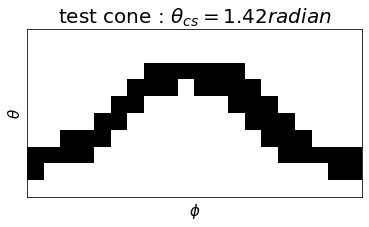

In [354]:
plt.imshow(intersection,cmap = "Greys")
plt.ylabel('$\\theta$')
plt.xlabel('$\phi$')
plt.title('test cone : $\\theta_{cs}=1.42radian$')
plt.xticks([])
plt.yticks([])
#plt.savefig('',pdi=300')

In [327]:
#create sample with the cone parameter and intersection matrix
#the cone is our sample
X_test = lil_matrix((1,mesh_theta * mesh_phi))
Y_test = np.zeros((1))

In [328]:
Y_test[0] = theta_cs
X_test[0,:] = sp.sparse.csr_matrix(intersection.reshape(-1))

In [329]:
%%time
#predict the output(theta_cs) of sample(one cone)
Y_predict = best_model.predict(X_test)
Y_predict

Wall time: 53.9 ms


array([1.2842156])

In [379]:
%%time
mse = mean_squared_error(Y_test, Y_predict)
print('MSE:' ,mse)

MSE: 0.01767679593083423
Wall time: 0 ns


In [330]:
theta_cs_predict = Y_predict[0]

In [331]:
# generate the intersection matrix of the predict theta_cs and other parameters are the same as example cone
intersection_predict = cone_sphere_intersection(x_0,y_0,z_0,theta_cs_predict,n_x,n_y,n_z,phi_s,theta_s,mesh_theta,mesh_phi)

Text(0.5, 1.0, 'predict cone : $\\theta_{cs}=1.28radian$')

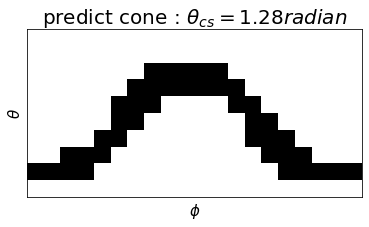

In [356]:
plt.imshow(intersection_predict,cmap = "Greys")
plt.ylabel('$\\theta$')
plt.xlabel('$\phi$')
plt.xticks([])
plt.yticks([])
plt.title('predict cone : $\\theta_{cs}=1.28radian$')

Text(0.5, 1.0, 'test and predict')

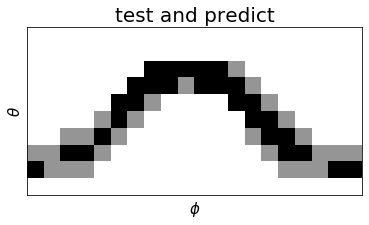

In [357]:
plt.imshow(intersection + intersection_predict,cmap = "Greys")
plt.ylabel('$\\theta$')
plt.xlabel('$\phi$')
plt.xticks([])
plt.yticks([])
plt.title('test and predict')

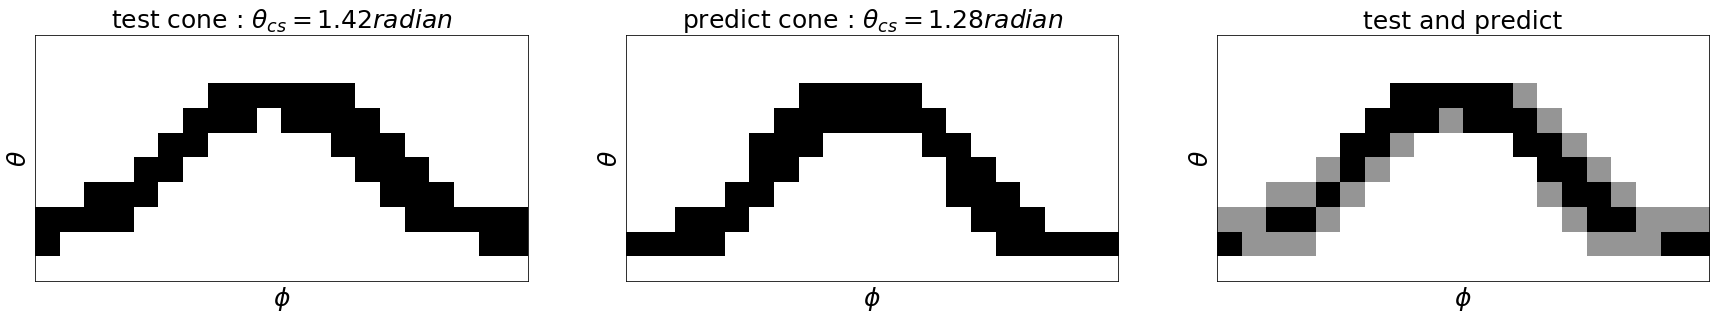

In [378]:
fig,(ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(30,10))

ax1.imshow(intersection,cmap = "Greys")
ax1.set_ylabel('$\\theta$',fontsize=25)
ax1.set_xlabel('$\phi$',fontsize=25)
ax1.set_title('test cone : $\\theta_{cs}=1.42radian$',fontsize=25)
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(intersection_predict,cmap = "Greys")
ax2.set_ylabel('$\\theta$',fontsize=25)
ax2.set_xlabel('$\phi$',fontsize=25)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('predict cone : $\\theta_{cs}=1.28radian$',fontsize=25)

ax3.imshow(intersection + intersection_predict,cmap = "Greys")
ax3.set_ylabel('$\\theta$',fontsize=25)
ax3.set_xlabel('$\phi$',fontsize=25)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('test and predict',fontsize=25)

plt.savefig('cones.png',dpi=300)